# Семинар 10. Восстановление нелинейных зависимостей с помощью линейных моделей. Решающие деревья.

## Добавление нелинейных признаков в модели

### Регрессия

Вспомним пример из предыдущего семинара:

Рассмотрим задачу регрессии, где зависимсть имеет следующий вид: $y = x * \sin(x)$

In [170]:
import numpy as np
import pylab as plt
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [171]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

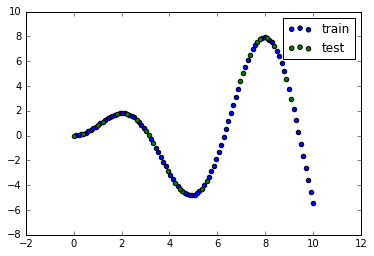

In [172]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
_ = plt.legend(('train', 'test'))

Если мы попробудем решить эту задачи с помощью известной нам линейной регрессии, то построенная модель будет слабо отражать истинную зависимость:

In [124]:
from sklearn.linear_model import LinearRegression

In [125]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

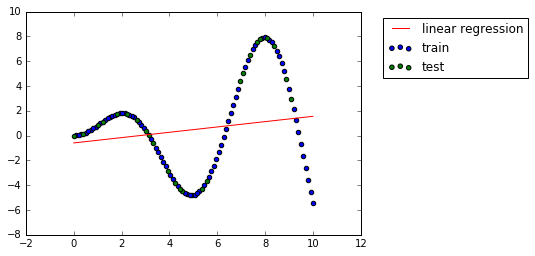

In [126]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Поэтому иногда в таких случаях в модель вводят нелинейные признаки — некоторые нелинейные комбинации исходных признаков. Например, можно ввести полиномиальные признаки. То есть если раньше был один признак $x^1$, то теперь получатся признаки: $1, x^1, (x^1)^2, \dots, (x^1)^d$, где $d$ — степень выбранного полинома.

In [127]:
from sklearn.preprocessing import PolynomialFeatures

В нашем случае рассмотрим полином 4 степени:

In [128]:
poly = PolynomialFeatures(degree=4)
poly.fit(X_train[:, np.newaxis])

PolynomialFeatures(degree=4, include_bias=True, interaction_only=False)

In [129]:
new_features = poly.transform(X_train[:, np.newaxis])
new_test_features = poly.transform(X_test[:, np.newaxis])

In [130]:
lr2 = LinearRegression()
lr2.fit(new_features, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

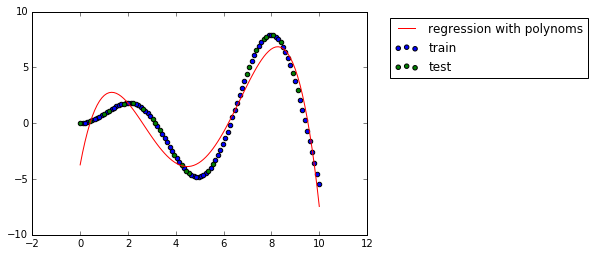

In [131]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr2.predict(poly.transform(X[:, np.newaxis]))
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('regression with polynoms', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Видно, что в данном случае это улучшило модель. Но если опять же вспомнить пример из предыдущего семинара, то чем больше мы увеличиваем степень, тем больше становится признаков и тем больше необходимо данных, чтобы хорошо обучить модель. Поэтому при возрастании степени полинома модель становится склонной к переобучению.

Работает ли этот подход для реальных данных? Давайте посмотрим. 

Вспомним про датасет *boston*, где в качестве объектов нам даны квартиры Бостона и необходимо построить модель, предсказывающую стоимость квартиры. 

Загрузим этот датасет:

In [132]:
from sklearn import datasets

In [133]:
boston = datasets.load_boston()

Ниже дано краткое описание этого датасета, в том числе признаков:

In [134]:
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Будем измерять качество модели с помощью коэффициента детерминации на кросс-валидации:

In [135]:
from sklearn.cross_validation import cross_val_score, KFold

Создадим объект, реализующий схему кросс-валидации по K блокам (в данном случае K = 5), укажем параметры *shuffle=True* чтобы перед разбиением на блоки данные были перемешаны, а также *random_state=42* — чтобы зафиксировать разбиение.

In [136]:
kfold = KFold(boston.target.shape[0], n_folds=5, shuffle=True, random_state=42)

Если для некоторой модели необходимо просто понять качество на кросс-валидации, то удобно воспользоваться функцией *cross_val_score*, которой на вход передаются:
 - модель
 - матрица объект-признак
 - столбец ответов
 
Помимо этого можно указать:
 - *scoring* — метрика, по которой оценивать качество
 - *cv* — схему кросс-валидации
 
После того как функция отработала, она вернет качество модели на каждом разбиениии (в данном случае, так как используется *5-fold*, всего будет 5 чисел).

Для сравнения моделей между собой можно усреднять качество и вычислять разброс значений:

In [137]:
scores = cross_val_score(LinearRegression(), boston.data, boston.target, scoring='r2', cv=kfold)
print "Mean r2 score:", np.mean(scores), "std:", np.std(scores)

Mean r2 score: 0.715147097604 std: 0.037602797767


Коэффициент детерминации получился достаточно высоким. Попробуем улучшить качество, добавив в модель квадратичные признаки: если раньше признаками были $x^1, x^2, \dots$, то теперь будут новые признаки: $1, x^1, x^2, x^1x^2, (x^1)^2, (x^2)^2, \dots$

In [20]:
poly = PolynomialFeatures(degree=2)
poly.fit(boston.data)
boston_poly_data = poly.transform(boston.data)

Обратите внимание, что даже при степени 2 количество признако растет драматически:

In [23]:
print "Features:", boston.data.shape[1]
print "Quadratic features:", boston_poly_data.shape[1]

Features: 13
Quadratic features: 105


Обучим нашу модель и посчитаем качество:

In [143]:
scores = cross_val_score(LinearRegression(), boston_poly_data, boston.target, 
                         scoring='r2', cv=kfold)
print "Mean r2 score:", np.mean(scores), "std:", np.std(scores)

Mean r2 score: 0.822452880521 std: 0.0488503911246


Видно, что качество возросло достаточно сильно (0.715 -> 0.822), однако пропала возможная интерпретируемость. Сложно понять, что означают признаки, например "среднее количество комнат * индекс преступности" или "среднее количество комнат в квадрате" и почему они хорошо повлияли на предсказание. 

### Классификация

А теперь вернемся к задачам классификации. Из ранее изученных можно вспомнить линейную модель классификации, которая записывается как $a(x) = sign(\langle w, x\rangle)$

Посмотрим как добавление нелинейных зависимость может повлиять на линейные модели.

Для начала вспомним в чем была проблема: линейный классификатор умеет строить только линейные разделяющие поверхности. То есть если данные разделимы линейно (возможно, с некоторым шумом), то все в порядке. Однако в более сложных случаях модель плохо описывает данные.

Для начала рассмотрим обычный датасет:

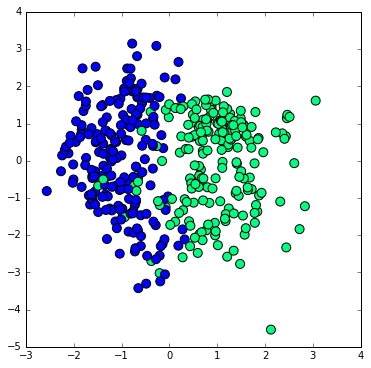

In [108]:
X_clf, y_clf = datasets.make_classification(400, n_features=2, n_redundant=0, n_classes=2, random_state=42)
plt.figure(figsize=(6, 6))
plt.scatter(X_clf[:, 0], X_clf[:, 1], c=y_clf, cmap='winter', s=80)

Воспользуемся логистической регрессией для построения предсказания:

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
def plot_decision_boundary(clf, X, transform, y):
    clf.fit(transform(X), y)
    plt.figure(figsize=(8, 8))
    xx1 = np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, 0.05)
    xx2 = np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, 0.05)

    X1, X2 = np.meshgrid(xx1, xx2)
    Z = np.empty(X1.shape)
    Z = clf.predict(transform(np.c_[X1.ravel(), X2.ravel()]))
    Z = Z.reshape(X1.shape)
    plt.contourf(X1, X2, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', s=100)

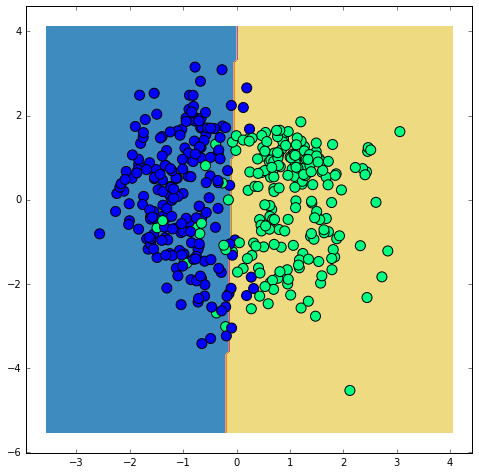

In [109]:
plot_decision_boundary(LogisticRegression(random_state=42), X_clf, lambda x: x, y_clf)

(небольшие *скачки* возникают из-за особенности построения графика)

А теперь посмотрим на случай нелинейно разделимой выборки:

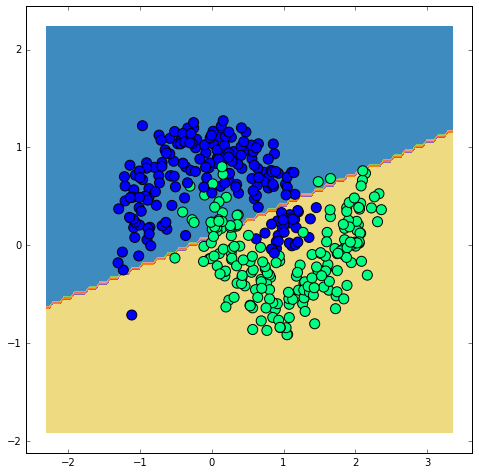

In [38]:
X_moons, y_moons = datasets.make_moons(400, noise=0.2, random_state=42)
plot_decision_boundary(LogisticRegression(random_state=42), X_moons, lambda x: x, y_moons)

На графике видно, что классификатор построил некоторую приямую, при этом есть большое число объектов, на которых он ошибся. 

И рассмотрим совсем линейно неразделимый случай:

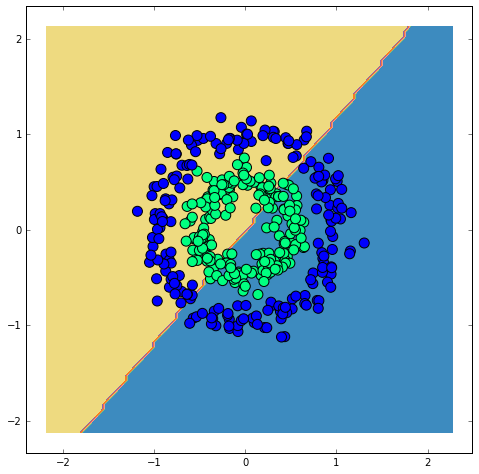

In [42]:
X_circles, y_circles = datasets.make_circles(400, noise=0.1, factor=0.5, random_state=42)
plot_decision_boundary(LogisticRegression(random_state=42), X_circles, lambda x: x, y_circles)

Не смотря на "очевидность" разделения объектов на классы, линейный клсссификатор с такой задачей справиться не может. Посмотрим что будет, если добавить в модель полиномиальные признаки.

Для начала добавим степени 2:

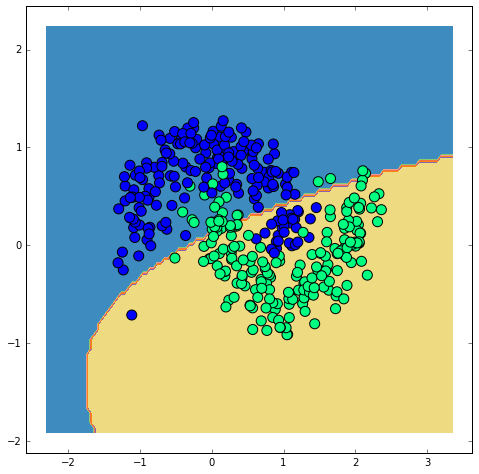

In [44]:
poly = PolynomialFeatures(degree=2)
poly.fit(X_moons)
X_poly_moons = poly.transform(X_moons)
plot_decision_boundary(LogisticRegression(random_state=42), X_moons, lambda x: poly.transform(x), y_moons)

Видно, что эта картинка очень похожа на полученную ранее. Попробуем увеличить степень:

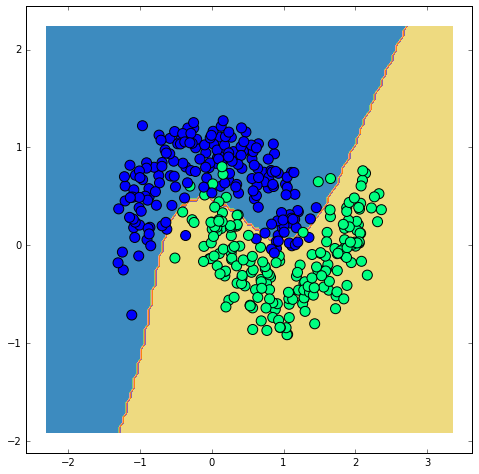

In [46]:
poly = PolynomialFeatures(degree=3)
poly.fit(X_moons)
X_poly_moons = poly.transform(X_moons)
plot_decision_boundary(LogisticRegression(random_state=42), X_moons, lambda x: poly.transform(x), y_moons)

В данном случае видно, что признаки степени 3 дали существенное улучшение для итоговой модели. 

Что же произойдет с самым сложным из рассмотренных случаев?

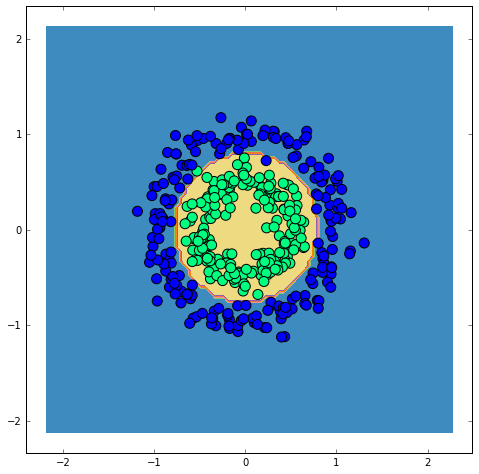

In [47]:
poly = PolynomialFeatures(degree=2)
poly.fit(X_circles)
X_poly_circles = poly.transform(X_circles)
plot_decision_boundary(LogisticRegression(random_state=42), X_circles, lambda x: poly.transform(x), y_circles)

Даже со степению 2 эти данные начали быть почти идеально разделимыми!

Давайте теперь посмотрим, как это работает на реальных данных. Рассмотрим небольшой датасет, в котором требуется предсказать, придет ли человек сдавать кровь в марте 2007, основываясь на следующих признаках:
 - количество месяцев с последней сдачи крови
 - сколько раз всего человек сдавал кровь
 - суммарное количество сданной крови
 - количество месяцев, как человек начал сдавать кровь

In [56]:
import pandas as pd

In [144]:
data = pd.read_csv('transfusion.data.txt')
data.head()

Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)  \
0                 2                 50                  12500             98   
1                 0                 13                   3250             28   
2                 1                 16                   4000             35   
3                 2                 20                   5000             45   
4                 1                 24                   6000             77   

   whether he/she donated blood in March 2007  
0                                           1  
1                                           1  
2                                           1  
3                                           1  
4                                           0

In [58]:
X, y = data.values[:, :-1], data.values[:, -1]

In [59]:
np.unique(y, return_counts=True)

(array([0, 1]), array([570, 178]))

Видно, что в данном случае данные сильно несбалансированные. Поэтому для оценки качества выберем метрику *AUC-ROC*.

In [60]:
kfold = KFold(y.shape[0], shuffle=True, n_folds=5, random_state=42)

In [61]:
scores = cross_val_score(LogisticRegression(random_state=42), X, y, cv=kfold, scoring='roc_auc')
print "AUC-ROC:", np.mean(scores), "std:", np.std(scores)

AUC-ROC: 0.748586484568 std: 0.0491387264619


Так как данные находятся в разных масштабах, отнормируем их:

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [64]:
scores = cross_val_score(LogisticRegression(random_state=42), X_scaled, y, cv=kfold, scoring='roc_auc')
print "AUC-ROC:", np.mean(scores), "std:", np.std(scores)

AUC-ROC: 0.74994962393 std: 0.0512224448559


После масштабирование стало немного лучше. Не забывайте обращать внимание на это, при использовании линейных методов!

Как было замечено ранее, некоторые полиномиальные признаки сложно интерпретировать. Поэтому попробуем придумать свои, например: посмотреть сколько крови человек сдает за раз или за месяц. Заметим, что такие признаки не мог возникнуть при полиномиальных признаках. 

In [92]:
mean_blood = 1.0 * X[:, 2] / X[:, 1]
mean_month = X[:, 2] / X[:, 3]
new_features = np.concatenate([mean_blood[:, np.newaxis], mean_month[:, np.newaxis]], axis=1)
new_features_scaled = scaler.fit_transform(new_features)

In [94]:
X_all = np.concatenate([X_scaled, new_features_scaled], axis=1)

scores = cross_val_score(LogisticRegression(random_state=42), X_all, y, cv=kfold, scoring='roc_auc')
print "AUC-ROC:", np.mean(scores), "std:", np.std(scores)

AUC-ROC: 0.751248597882 std: 0.050677183663


Даже добавление двух признаков немного улучшило качество модели, при этом она не потеряла интерпретируемость. 

## Решающие деревья

На лекции рассматривался новый класс моделей: решающие деревья (или деревья решений). Проще всего представить его визуально. Рассмотрим знакомый вам датасет ирисы Фишера:

In [148]:
iris = datasets.load_iris()

Вспомним как выглядит *scatter_matrix*. По ней вижно что признак *petal length* хорошо отделяет один вид ирисов от двух других:

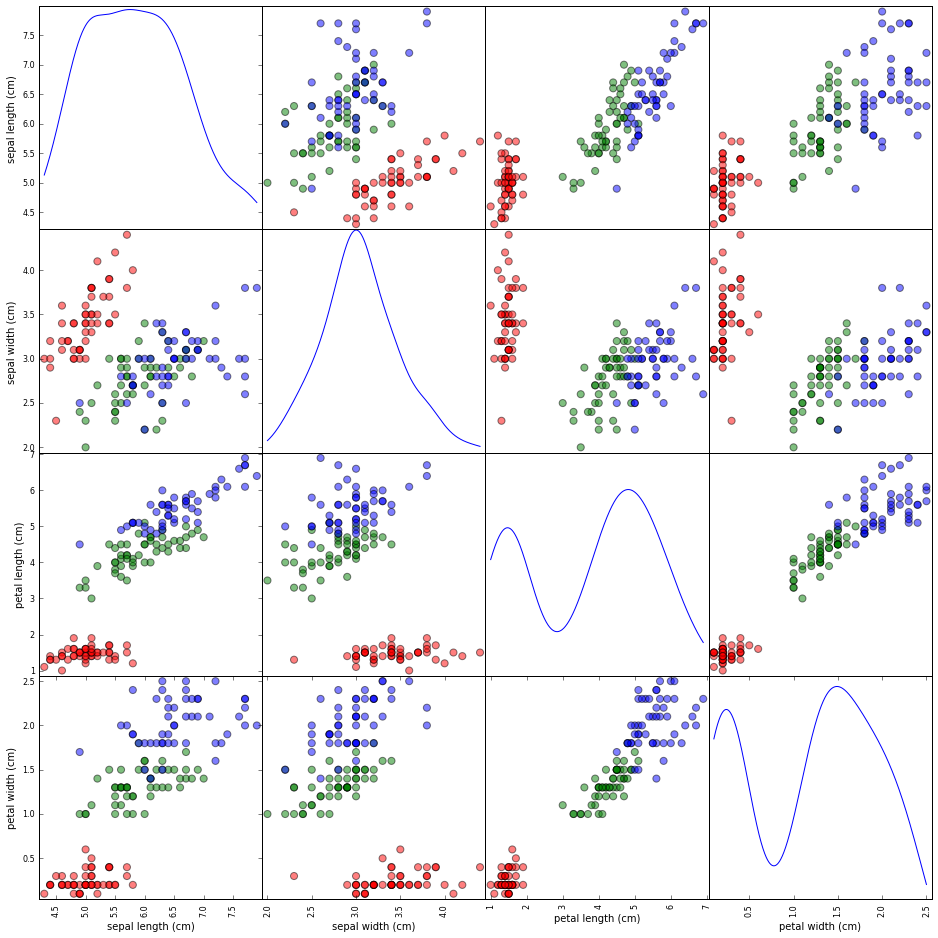

In [149]:
from pandas.tools.plotting import scatter_matrix

iris = datasets.load_iris()
data = pd.DataFrame(iris['data'], columns=iris['feature_names'])
c = ["red", "green", "blue"]
colors = [c[i] for i in iris['target']]
_ = scatter_matrix(data, figsize=(16, 16), diagonal='kde', s=200, c=colors)

Теперь посмотрим, как будет выглядеть решающее дерево для данного случая:

In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [116]:
iris.keys()

['target_names', 'data', 'target', 'DESCR', 'feature_names']

In [150]:
?DecisionTreeClassifier

In [153]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(iris.data, iris.target)
tree.export_graphviz(clf, out_file='tree2.dot', feature_names=data.columns, 
                     leaves_parallel=True, class_names=iris.target_names)     

In [154]:
!dot -Tpng tree2.dot -o tree2.png

![](http://i.imgur.com/0dEwFab.png)

Дерево состоит из внутренних вершин и листьев. Во внутренних вершинах происходит решение куда пойдет данный объект, основываясь на условии. В листьях принимается решение о том, какой класс (или значение в случае регрессии) будет иметь  объект.

Можно обратить внимание, что решающие деревья не чувствительны к масштабу признаков, в отличии от линейных моделей. Кроме того, они позволяют строить произвольные разделяющие поверхности. Посмотрим как будут выглядеть разделяющие поверхности, построенные с помощью решающих деревьев, на рассмотренных ранее примерах.

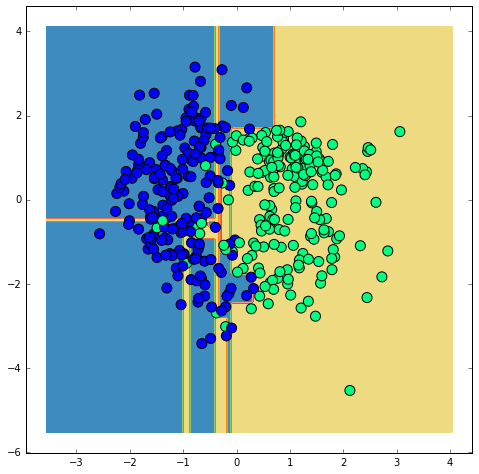

In [155]:
plot_decision_boundary(DecisionTreeClassifier(random_state=42), X_clf, lambda x: x, y_clf)

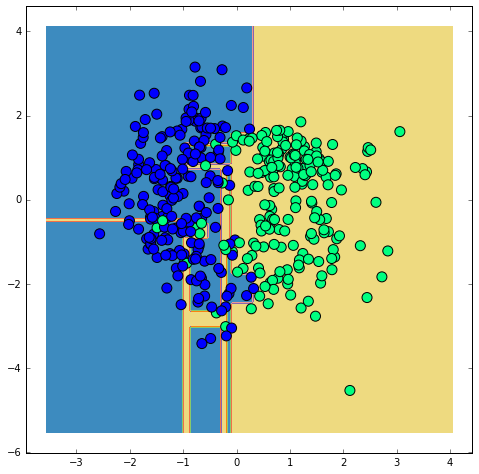

In [169]:
plot_decision_boundary(DecisionTreeClassifier(random_state=42, criterion='entropy'), X_clf, lambda x: x, y_clf)

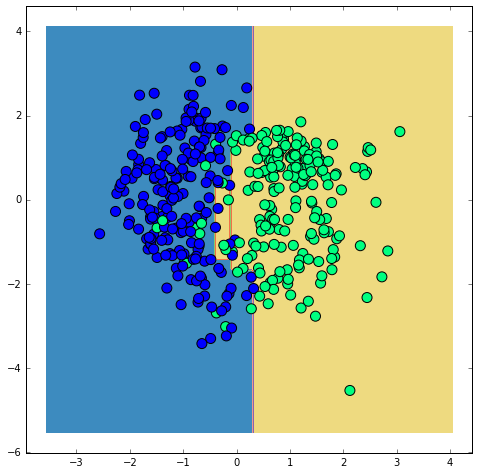

In [167]:
plot_decision_boundary(DecisionTreeClassifier(random_state=42, min_samples_leaf=5), X_clf, lambda x: x, y_clf)

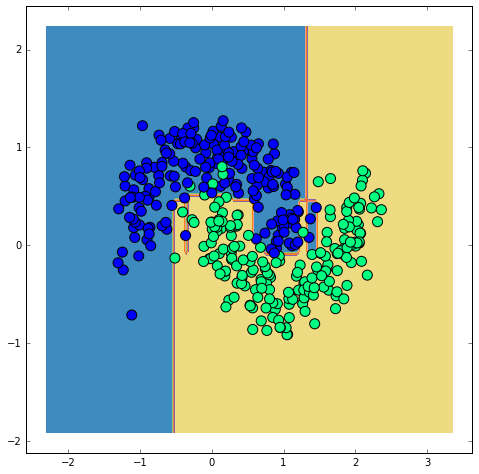

In [112]:
plot_decision_boundary(tree.DecisionTreeClassifier(random_state=42), X_moons, lambda x: x, y_moons)

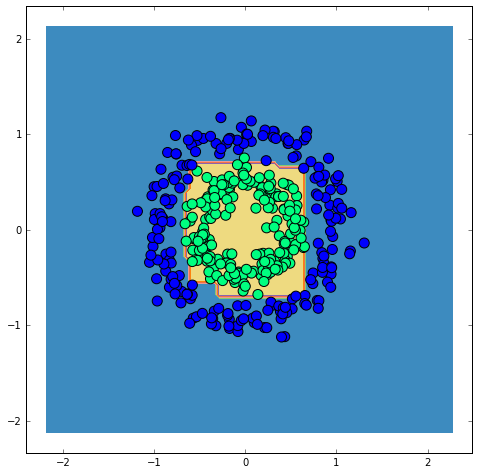

In [157]:
plot_decision_boundary(tree.DecisionTreeClassifier(random_state=42), X_circles, lambda x: x, y_circles)

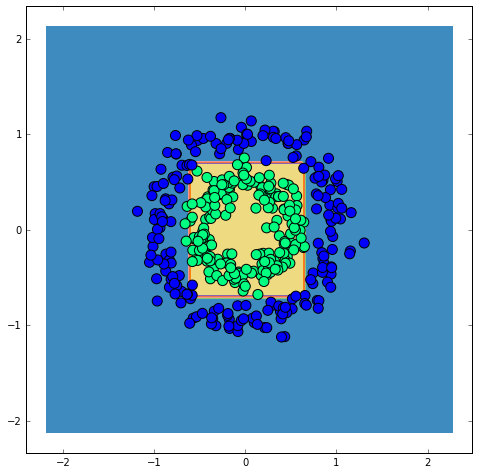

In [175]:
plot_decision_boundary(tree.DecisionTreeClassifier(random_state=42, max_depth=4), X_circles, lambda x: x, y_circles)

По изображениям видно, что решающие деревья обладают меньшей обобщающей способностью (в сравнении с линейными методами), так как иногда решение формируется исходя всего из одного объекта.

Неплохие [видео](https://www.coursera.org/learn/process-mining/home/week/1) про решающие деревья.